# Required Installations of Spark & Java and set up of Environment Variables.

In [63]:
import os
# Find the latest version of spark 3.2 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


In [64]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.5.1.jar

--2023-03-27 21:14:34--  https://jdbc.postgresql.org/download/postgresql-42.5.1.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1046770 (1022K) [application/java-archive]
Saving to: ‘postgresql-42.5.1.jar.2’

postgresql-42.5.1.j 100%[===================>]   1022K  1.58MB/s    in 0.6s    

2023-03-27 21:14:35 (1.58 MB/s) - ‘postgresql-42.5.1.jar.2’ saved [1046770/1046770]



# Load Amazon Data into Spark DataFrame
## Get the Country latitude and longitude details with GDP

In [65]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FinalProject-WomenWellBeing").config("spark.driver.extraClassPath","/content/postgresql-42.5.1.jar").getOrCreate()


In [66]:
from pyspark import SparkFiles
url = "https://mywomenwellbeing.s3.us-west-1.amazonaws.com/Livwell_in_interpolated.csv"
spark.sparkContext.addFile(url)

livewell_df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("Livwell_in_interpolated.csv"), sep=",", header=True, inferSchema=True)
livewell_df.show()


+------------+------------+----+---------------------+----------------------+---------+-------------------+--------------------+------------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+----------------+-------------------+-----------+--------------+---------------+------------------+---------+------------+-------------+----------------+----------+-------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+------------------------------------+-----------------------+--------------------------+-------------------------------

### Load the dataframe with required columns and clean the data.

In [67]:
livewell_orginal_df =livewell_df
livewell_df.summary().show()




+-------+------------+------------+------------------+---------------------+----------------------+---------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+-----------

## Convert PySpark dataframe to pandas data frame for etl process.

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:



import pandas as pd

livewell_etl_df = livewell_df.toPandas()


livewell_etl_df.shape

(7370, 407)

### Drop the unnecessary columns and drop the null values and store the clean data into a new dataframe.

In [70]:
livewell_etl_df =livewell_etl_df.dropna()
livewell_etl_df = livewell_etl_df.drop(columns=['region_num_harmonized','region_name_harmonized','SurveyId','interview_year_mean','interview_month_mean','CMC_interview_mean'],axis=1)
livewell_etl_df.columns

Index(['country_name', 'country_code', 'year', 'DM_age_15.19_p',
       'DM_age_15.19_p_se', 'DM_age_20.24_p', 'DM_age_20.24_p_se',
       'DM_age_25.29_p', 'DM_age_25.29_p_se', 'DM_age_30.34_p',
       ...
       'EI_computer_p', 'EI_computer_p_se', 'DP_decide_no_contraception_p',
       'DP_decide_no_contraception_p_se', 'EI_internet_day_p',
       'EI_internet_day_p_se', 'EI_internet_week_p', 'EI_internet_week_p_se',
       'EI_mobile_p', 'EI_mobile_p_se'],
      dtype='object', length=401)

In [71]:
import numpy as np
# print(livewell_etl_df.dtypes[['country_name','DV_phys_or_sex_partner_p','DM_age_mean','DM_marr_p',	'DM_age_marr_mean',	'ED_educ_years_mean',	'FF_TFR']])
df = livewell_etl_df
mean_cols = list(df.columns[df.columns.str.endswith('_mean')])
mean_cols.insert(0,"year") 
mean_cols.insert(1,"country_name") 
mean_cols.insert(2,"DV_phys_or_sex_partner_p")
mean_cols.insert(3,"FF_TFR")
mean_cols.insert(4,"WK_working_p")
mean_cols.insert(5,"DM_urban_p")
mean_cols.insert(6,"DM_marr_p")
mean_cols.insert(7,"DM_age_marr_mean")
mean_cols.insert(8,"DM_age_mean")
mean_cols.insert(9,"DP_decide_health_p")
mean_cols.insert(10,"hdi")

df = df.replace('NA',np.NAN)
df = df.astype({'WK_working_p':'float',
                'DM_urban_p': 'float',
                'DM_marr_p':'float',
                'DM_age_mean':'float',
                'DM_age_marr_mean': 'float',
                'DV_phys_or_sex_partner_p':'float',
                'ED_educ_years_mean':'float',  
                'DP_decide_health_p' :'float',
                'hdi':'float'})

df[mean_cols]
mean_indicators_df = df.loc[df['year']>=2000]

mean_indicators_df = mean_indicators_df.groupby(['country_name'])[mean_cols].mean()

print(mean_indicators_df.columns)
mean_indicators_df =mean_indicators_df.reset_index()
mean_indicators_df = mean_indicators_df.loc[:,['country_name','DV_phys_or_sex_partner_p','DM_age_mean',	'DM_age_marr_mean','WK_working_p','DM_urban_p',	'DM_marr_p',	'ED_educ_years_mean',	'FF_TFR', 'DP_decide_health_p','hdi']]
mean_indicators_df.to_csv("Livewell_ML_Indicators.csv")



Index(['year', 'DV_phys_or_sex_partner_p', 'FF_TFR', 'WK_working_p',
       'DM_urban_p', 'DM_marr_p', 'DM_age_marr_mean', 'DM_age_mean',
       'DP_decide_health_p', 'hdi', 'DM_age_marr_mean', 'DM_age_mean',
       'ED_educ_years_mean', 'HD_children_mean', 'HD_size_dejure_mean',
       'WL_wealth_mean'],
      dtype='object')


## Read the country data from PostgresSQL for further analysis.

In [72]:
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




### Connection credentials dictionary is created.



In [73]:

import psycopg2 as posgresSql
# define credentials 
credentials = {'POSTGRES_ADDRESS' : 'womenwellbeingdatabase.cd7e8xnrkvlm.us-west-1.rds.amazonaws.com', # change to your endpoint
               'POSTGRES_PORT' : '5432', # change to your port
               'POSTGRES_USERNAME' : 'postgres', # change to your username
               'POSTGRES_PASSWORD' : 'postgres', # change to your password
               'POSTGRES_DBNAME' : 'postgres'} # change to your db name


# create connection and cursor    
conn = posgresSql.connect(host=credentials['POSTGRES_ADDRESS'],
                  database=credentials['POSTGRES_DBNAME'],
                  user=credentials['POSTGRES_USERNAME'],
                  password=credentials['POSTGRES_PASSWORD'],
                  port=credentials['POSTGRES_PORT'])

table_conn = conn.cursor()

In [74]:

import pandas as pd

# tablename = 'CountryDemographics'
# query = f"""SELECT * FROM {tablename};"""

query = """SELECT * FROM CountryGDPDemographics;"""

table_conn.execute(query=query)
country_df = pd.DataFrame(table_conn.fetchall(), columns= ['country_name','country_code','latitude','longitude','GDP'])

In [75]:
country_df

country_df.to_csv("CountryDemographics.csv")

## Combine the Country and Indicators ETL into one dataframe.

In [76]:

mean_indicators_df =mean_indicators_df.set_index('country_name')
country_df = country_df.set_index('country_name')

In [77]:

combined_df = mean_indicators_df.join(country_df)


# combined_df.shape

combined_df.to_csv('Country_Indicators.csv')
# combined_df.columns

combined_df.head()

,DV_phys_or_sex_partner_p,DM_age_mean,DM_age_mean,DM_age_marr_mean,DM_age_marr_mean,WK_working_p,DM_urban_p,DM_marr_p,ED_educ_years_mean,FF_TFR,DP_decide_health_p,hdi,country_code,latitude,longitude,GDP
country_name,,,,,,,,,,,,,,,,
Armenia,9.176364,31.333770,31.333770,20.173957,20.173957,30.566952,45.547567,65.135775,10.634626,1.777382,23.497433,0.689230,AM,40.069099,45.038189,7.721111e+09
Bangladesh,45.628000,25.935778,25.935778,15.317056,15.317056,22.471333,19.041444,79.065833,3.770611,2.608617,11.780000,0.523559,BD,23.684994,90.356331,1.148810e+11
Benin,22.211667,28.747139,28.747139,18.500306,18.500306,74.783259,40.152454,73.541259,2.392537,5.559406,17.733039,0.435762,BJ,9.307690,2.315834,6.378661e+09
Bolivia,NaN,29.193333,29.193333,19.904167,19.904167,57.241750,65.327083,60.119750,8.025083,3.904192,44.331250,0.622006,BO,-16.290154,-63.588653,1.934660e+10
Burkina Faso,11.683077,28.893461,28.893461,17.414231,17.414231,83.028462,18.662692,79.760385,1.301154,6.067308,8.325000,0.346412,BF,12.238333,-1.561593,7.912032e+09


## Find the dependant features for the unsupervised learning and predict

In [78]:
!pip install Scikit-learn
!pip install sklearn
!pip install plotly
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

ML_Combined_df = combined_df


ML_indicators_df = mean_indicators_df.loc[:,['DM_age_mean',	'DM_age_marr_mean','WK_working_p','DM_urban_p',	'DM_marr_p',	'ED_educ_years_mean',	'FF_TFR']]
ML_indicators_df = ML_indicators_df.reset_index()
ML_indicators_df.columns
print(ML_indicators_df.describe())
# Use get_dummies() to create variables for text features.
ML_features_df = pd.get_dummies(ML_indicators_df)
print(ML_features_df.shape)

ML_features_df




       DM_age_mean  DM_age_mean  DM_age_marr_mean  DM_age_marr_mean  \
count    52.000000    52.000000         52.000000         52.000000   
mean     27.972105    27.972105         18.858132         18.858132   
std       2.165867     2.165867          1.517500          1.517500   
min      19.332463    19.332463         15.317056         15.317056   
25%      27.851493    27.851493         18.069863         18.069863   
50%      28.486627    28.486627         18.676219         18.676219   
75%      29.008532    29.008532         19.903496         19.903496   
max      31.333770    31.333770         22.973056         22.973056   

       WK_working_p  DM_urban_p  DM_marr_p  ED_educ_years_mean     FF_TFR  
count     52.000000   52.000000  52.000000           52.000000  52.000000  
mean      50.336875   36.291180  63.822832            5.331920   4.328943  
std       19.415121   15.746404   9.008500            2.439971   1.323595  
min        8.775630   10.072171  38.641044            1.

,DM_age_mean,DM_age_mean,DM_age_marr_mean,DM_age_marr_mean,WK_working_p,DM_urban_p,DM_marr_p,ED_educ_years_mean,FF_TFR,country_name_Armenia,...,country_name_South Africa,country_name_Tajikistan,country_name_Tanzania,country_name_Timor-Leste,country_name_Togo,country_name_Turkey,country_name_Uganda,country_name_Vietnam,country_name_Zambia,country_name_Zimbabwe
0,31.333770,31.333770,20.173957,20.173957,30.566952,45.547567,65.135775,10.634626,1.777382,1,...,0,0,0,0,0,0,0,0,0,0
1,25.935778,25.935778,15.317056,15.317056,22.471333,19.041444,79.065833,3.770611,2.608617,0,...,0,0,0,0,0,0,0,0,0,0
2,28.747139,28.747139,18.500306,18.500306,74.783259,40.152454,73.541259,2.392537,5.559406,0,...,0,0,0,0,0,0,0,0,0,0
3,29.193333,29.193333,19.904167,19.904167,57.241750,65.327083,60.119750,8.025083,3.904192,0,...,0,0,0,0,0,0,0,0,0,0
4,28.893461,28.893461,17.414231,17.414231,83.028462,18.662692,79.760385,1.301154,6.067308,0,...,0,0,0,0,0,0,0,0,0,0
5,27.701250,27.701250,19.936250,19.936250,70.646250,28.498750,54.403750,4.436250,5.567125,0,...,0,0,0,0,0,0,0,0,0,0
6,29.756852,29.756852,19.504019,19.504019,68.783481,16.504426,63.113574,4.170741,3.502878,0,...,0,0,0,0,0,0,0,0,0,0
7,27.703113,27.703113,18.511604,18.511604,62.059623,57.112547,60.546887,6.927547,4.782745,0,...,0,0,0,0,0,0,0,0,0,0
8,30.338791,30.338791,20.130000,20.130000,53.067143,78.415055,52.676484,8.944835,2.284516,0,...,0,0,0,0,0,0,0,0,0,0
9,28.156818,28.156818,18.145455,18.145455,65.836364,39.645909,66.182273,5.460909,6.612091,0,...,0,0,0,0,0,0,0,0,0,0


### Apply standard scalar to fit and transform

In [80]:

# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
ML_scaled_df = data_scaler.fit_transform(ML_features_df)
ML_scaled_df[:5]

array([[ 1.56725387,  1.56725387,  0.87556042,  0.87556042, -1.02820914,
         0.59357648,  0.14716687,  2.19446859, -1.94655803,  7.14142843,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801],
       [-0.94936305, -0.94936305, -2.35625923, -2.35625923, -1.44925219,
        -1.10615917,  1.70857

## Feature reduction using PCA

In [81]:
# Using PCA to reduce dimension to three principal components.
# Initialize PCA model
pca = PCA(n_components=3)
# Get two principal components for the combined data.
ML_pca = pca.fit_transform(ML_scaled_df)
ML_pca.shape

(52, 3)

In [82]:
# Create a DataFrame with the three principal components.
# YOUR CODE HERE
ML_pca_df = pd.DataFrame(data=ML_pca,
columns={'PCA1','PCA2','PCA3'})
# ML_pca_df =ML_pca_df.set_index(ML_Combined_df.index)
ML_pca_df

,PCA2,PCA3,PCA1
0,3.125541,-1.717424,2.634605
1,-3.218530,2.622839,3.651723
2,-1.805310,-1.233637,-0.882415
3,2.149641,-1.424960,0.635708
4,-3.772538,-1.323514,-1.316418
5,0.320355,-0.375594,-2.891892
6,-0.053437,-1.170179,-1.329332
7,0.418128,-0.568277,0.303611
8,3.703379,-2.009753,1.876974
9,-1.309959,-1.015568,-0.842298


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

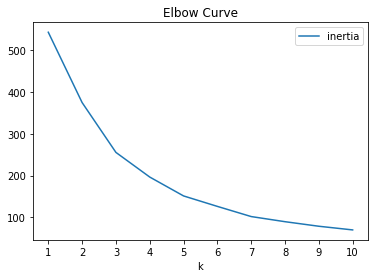

In [83]:
# Create an elbow curve to find the best value for K.
# Find the best value for K

from sklearn.cluster import KMeans
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(ML_pca_df)
    inertia.append(km.inertia_)


# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

df_elbow.plot(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot = df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot
# df_elbow

In [84]:
# Initialize the K-Means model.
# YOUR CODE HERE
model = KMeans(n_clusters=3, random_state=5)
# Fit the model
# YOUR CODE HERE
model.fit(ML_pca_df)
# Predict clusters
# YOUR CODE HERE
predictions = model.predict(ML_pca_df)


len(predictions)

52

In [85]:
combined_df.head()

,DV_phys_or_sex_partner_p,DM_age_mean,DM_age_mean,DM_age_marr_mean,DM_age_marr_mean,WK_working_p,DM_urban_p,DM_marr_p,ED_educ_years_mean,FF_TFR,DP_decide_health_p,hdi,country_code,latitude,longitude,GDP
country_name,,,,,,,,,,,,,,,,
Armenia,9.176364,31.333770,31.333770,20.173957,20.173957,30.566952,45.547567,65.135775,10.634626,1.777382,23.497433,0.689230,AM,40.069099,45.038189,7.721111e+09
Bangladesh,45.628000,25.935778,25.935778,15.317056,15.317056,22.471333,19.041444,79.065833,3.770611,2.608617,11.780000,0.523559,BD,23.684994,90.356331,1.148810e+11
Benin,22.211667,28.747139,28.747139,18.500306,18.500306,74.783259,40.152454,73.541259,2.392537,5.559406,17.733039,0.435762,BJ,9.307690,2.315834,6.378661e+09
Bolivia,NaN,29.193333,29.193333,19.904167,19.904167,57.241750,65.327083,60.119750,8.025083,3.904192,44.331250,0.622006,BO,-16.290154,-63.588653,1.934660e+10
Burkina Faso,11.683077,28.893461,28.893461,17.414231,17.414231,83.028462,18.662692,79.760385,1.301154,6.067308,8.325000,0.346412,BF,12.238333,-1.561593,7.912032e+09


In [86]:

combined_df = combined_df.reset_index()

clustered_df = combined_df.join(ML_pca_df)

clustered_df['class'] = predictions
# # Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)


(52, 21)


,country_name,DV_phys_or_sex_partner_p,DM_age_mean,DM_age_mean,DM_age_marr_mean,DM_age_marr_mean,WK_working_p,DM_urban_p,DM_marr_p,ED_educ_years_mean,...,DP_decide_health_p,hdi,country_code,latitude,longitude,GDP,PCA2,PCA3,PCA1,class
0,Armenia,9.176364,31.333770,31.333770,20.173957,20.173957,30.566952,45.547567,65.135775,10.634626,...,23.497433,0.689230,AM,40.069099,45.038189,7.721111e+09,3.125541,-1.717424,2.634605,1
1,Bangladesh,45.628000,25.935778,25.935778,15.317056,15.317056,22.471333,19.041444,79.065833,3.770611,...,11.780000,0.523559,BD,23.684994,90.356331,1.148810e+11,-3.218530,2.622839,3.651723,0
2,Benin,22.211667,28.747139,28.747139,18.500306,18.500306,74.783259,40.152454,73.541259,2.392537,...,17.733039,0.435762,BJ,9.307690,2.315834,6.378661e+09,-1.805310,-1.233637,-0.882415,0
3,Bolivia,NaN,29.193333,29.193333,19.904167,19.904167,57.241750,65.327083,60.119750,8.025083,...,44.331250,0.622006,BO,-16.290154,-63.588653,1.934660e+10,2.149641,-1.424960,0.635708,1
4,Burkina Faso,11.683077,28.893461,28.893461,17.414231,17.414231,83.028462,18.662692,79.760385,1.301154,...,8.325000,0.346412,BF,12.238333,-1.561593,7.912032e+09,-3.772538,-1.323514,-1.316418,0
5,Burundi,42.982500,27.701250,27.701250,19.936250,19.936250,70.646250,28.498750,54.403750,4.436250,...,13.602500,NaN,BI,-3.373056,29.918886,1.865821e+09,0.320355,-0.375594,-2.891892,0
6,Cambodia,16.259000,29.756852,29.756852,19.504019,19.504019,68.783481,16.504426,63.113574,4.170741,...,45.075861,0.498964,KH,12.565679,104.990963,1.084358e+10,-0.053437,-1.170179,-1.329332,0
7,Cameroon,43.352547,27.703113,27.703113,18.511604,18.511604,62.059623,57.112547,60.546887,6.927547,...,16.375377,0.475678,CM,7.369722,12.354722,2.366201e+10,0.418128,-0.568277,0.303611,1
8,Colombia,38.545714,30.338791,30.338791,20.130000,20.130000,53.067143,78.415055,52.676484,8.944835,...,72.876813,0.688128,CO,4.570868,-74.297333,2.296504e+11,3.703379,-2.009753,1.876974,1
9,Congo Democratic Republic,56.202273,28.156818,28.156818,18.145455,18.145455,65.836364,39.645909,66.182273,5.460909,...,15.918182,0.398730,CG,-0.228021,15.827659,2.175171e+10,-1.309959,-1.015568,-0.842298,0


In [87]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color="class",
    symbol="class",
    hover_name="country_name",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [88]:
clustered_df.columns
clustered_df = clustered_df.fillna(0) 
clustered_df.to_csv("Women_Wellbeing_data.csv")

In [89]:
!pip freeze > requirements.txt